In [1]:
!nvidia-smi

Mon Nov 20 22:45:47 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...    Off | 00000000:01:00.0  On |                  N/A |
| N/A   56C    P5              12W /  60W |    557MiB /  6144MiB |     41%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
#%%capture
#%pip uninstall --yes torchaudio
#%pip install -U torch torchvision torchdata --index-url https://download.pytorch.org/whl/cu118
#%pip install -U lightning
#%pip install wandb
#%pip install python-dotenv

In [3]:
import os
import shutil

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import compute_class_weight

import torch
import torchvision
import torchmetrics

import torchdata.datapipes as dp
from torch.utils.data import DataLoader
torchvision.disable_beta_transforms_warning();

import torchvision.transforms.v2 as t
from torchvision.models import alexnet, AlexNet_Weights

from lightning import LightningModule, Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger, WandbLogger

import wandb

from tqdm import tqdm
from typing import Callable
from dotenv import load_dotenv
load_dotenv();

from datamodules import ImagenetteDataModule
from models import AlexNet
from hyperparameters import Hyperparameters

#import logging
#logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)
#logging.getLogger("wandb").setLevel(logging.WARNING)

os.environ["WANDB_NOTEBOOK_NAME"] = (Path.cwd() / "experiments.ipynb").as_posix()

In [4]:
IMAGENETTE = Path.home() / "datasets" / "imagenette"

LOGS_DIR = Path.cwd() / "logs"
CHECKPOINTS_DIR = Path.cwd() / "checkpoints"

def reset_logs(logs_dir = Path.cwd() / "logs", checkpoints_dir = Path.cwd() / "checkpoints") -> None:
    if checkpoints_dir.is_dir():
        shutil.rmtree(checkpoints_dir.as_posix())
    checkpoints_dir.mkdir()

    if logs_dir.is_dir():
        shutil.rmtree(logs_dir.as_posix())
    logs_dir.mkdir()

reset_logs()

In [5]:
class ClassificationModel(LightningModule):
    def __init__(self, model, params: Hyperparameters):
        super().__init__()
        self.model = model

        #TODO : Add dicts for Metrics, Optimizers, Criterions
        self.task = params.task
        self.num_classes = params.num_classes
        self.criterion = params.criterion
        self.optimizer = params.optimizer
        self.learning_rate = params.learning_rate
        self.momentum = params.momentum
        self.weight_decay = params.weight_decay

        self._set_metrics()
        self.save_hyperparameters(
            {i:params.get_litmodule_hparams()[i] 
             for i in params.get_litmodule_hparams().keys() if i!='criterion'},
            ignore = ["model", "params"]
        ) 

    def forward(self, batch):
        x, _ = batch
        return self.model(x)

    def _forward_pass(self, batch, metrics : Callable | None = None) -> tuple:
        x, y = batch
        y_pred = self.model(x)
        if metrics:
            metrics.update(y_pred, y) 
        return self.criterion(y_pred, y), y_pred #type: ignore

    def _set_metrics(self):
        metrics = {"accuracy": torchmetrics.Accuracy(
                                task="multiclass",
                                num_classes=self.num_classes, 
                                average="macro"),

                   "f1" : torchmetrics.F1Score(
                                task="multiclass",
                                num_classes=self.num_classes,
                                average="macro")
                  }

        self.val_losses = list()
        self.val_metrics = torchmetrics.MetricCollection(
            metrics=metrics.copy(), prefix = "val_"
        )
        self.val_confm = torchmetrics.ConfusionMatrix(
            task = "multiclass", num_classes = self.num_classes,
        )

        self.test_metrics = torchmetrics.MetricCollection(
            metrics=metrics.copy(), prefix = "test_"
        )
        self.test_confm = torchmetrics.ConfusionMatrix(
            task = "multiclass", num_classes = self.num_classes,
        )

    def training_step(self, batch, batch_idx):
        loss, _ = self._forward_pass(batch)
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        _, y = batch
        loss, y_pred = self._forward_pass(batch)
        self.val_losses.append(loss)
        self.val_metrics.update(y_pred, y)
        self.val_confm.update(y_pred, y)
        #self.log("val_loss", loss, on_epoch=True, on_step=False)
        #self.log_dict(self.val_metrics, on_epoch=True, on_step=False) 
    
    def on_validation_epoch_end(self):
        val_losses_t = torch.tensor(self.val_losses)
        self.log("val_loss", val_losses_t.mean())
        self.val_losses.clear()

        self.log_dict(self.val_metrics.compute())
        self.val_metrics.reset()

        self.val_confm.compute()
        fig, _ = self.val_confm.plot();
        self.val_confm.reset()
        for logger in self.loggers:
            if isinstance(logger, WandbLogger):
                wandb.log({"val_confusion": fig})
        plt.clf();
        #del fig
    
    def test_step(self, batch, batch_idx):
        _, y = batch
        _, y_pred = self._forward_pass(batch)
        self.test_metrics.update(y_pred, y)
        self.test_confm.update(y_pred, y)
    
    def on_test_epoch_end(self):
        self.log_dict(self.test_metrics.compute())
        self.test_metrics.reset()

        self.test_confm.compute()
        fig_, _ = self.test_confm.plot();
        plt.show()
        self.test_confm.reset()
        for logger in self.loggers:
            if isinstance(logger, WandbLogger):
                wandb.log({"test_confusion": fig_})
        plt.clf();

    def configure_optimizers(self):
        return self.optimizer(params = self.model.parameters(),
                              lr = self.learning_rate,
                              momentum = self.momentum, 
                              weight_decay = self.weight_decay)

In [6]:
local_checkpoint = ModelCheckpoint(
    dirpath=CHECKPOINTS_DIR,
    filename="{epoch}-{train_loss:2f}-{val_loss:2f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    save_last=True,
)

local_logger = CSVLogger(
    save_dir=Path.cwd(),
    name="logs",
    version=1,
)

#wandb.finish()
wandb_logger = WandbLogger(
    save_dir=LOGS_DIR,
    project="ilsvrc",
    #log_model=True,
    name="alexnet-logging-test",
    version='1',
    offline=True
)

In [7]:
#imagenette_class_weights = torch.tensor([0.0982, 0.0990, 0.0952, 0.1102, 0.1005, 0.0989, 0.0984, 0.1016, 0.0994, 0.0985])
#imagenette_class_weights = torch.tensor([0.0765, 0.0830, 0.0568, 0.2547, 0.0962, 0.0822, 0.0780, 0.1072, 0.0866, 0.0788])
imagenette_class_weights = torch.tensor([.1, .1, .1, .1, .1, .1, .1, .1, .1, .1])

experiment = Hyperparameters(
    task = "multiclass_classification",
    random_seed = 42,
    num_classes = 10,
    metrics = ["accuracy", "f1"],

    criterion = torch.nn.CrossEntropyLoss(weight=imagenette_class_weights),
    optimizer = torch.optim.SGD,
    learning_rate = 1e-5,
    momentum = 0.9,
    weight_decay = 5e-4,
    #momentum=0,
    #weight_decay=0,

    batch_size = 128,
    grad_accum = 4,
    test_split = .3,
    transform = ["scale_[0,1]", "resize_256", "random_crop_224", "normalize", "hflip"],
    num_workers = 8,
)
seed_everything(experiment.random_seed, workers=True);

alexnet_pre = alexnet(weights = AlexNet_Weights.DEFAULT, dropout = 0.5)
alexnet_pre.classifier[-1] = torch.nn.Linear(4096, 10, bias = True)
torch.nn.init.xavier_normal_(alexnet_pre.classifier[-1].weight, torch.nn.init.calculate_gain("relu"))
torch.nn.init.zeros_(alexnet_pre.classifier[-1].bias)

alexnet_transform = t.Compose([
    t.ToImage(),
    t.ToDtype(torch.float32, scale = True),
    t.Resize(size = (256, 256), antialias = True),
    t.RandomCrop(size = (224, 224), pad_if_needed = True),
    t.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
    t.RandomHorizontalFlip(p = .5)
])
imagenette_dm = ImagenetteDataModule(
        root = IMAGENETTE, 
        params = experiment, 
        transform = alexnet_transform)

Seed set to 42


In [8]:
trainer = Trainer(
    #fast_dev_run=True,
    num_sanity_val_steps=0,
    #limit_train_batches=1,
    #limit_val_batches=2,
    #deterministic=True,
    #benchmark=True
    #enable_checkpointing=False,
    callbacks=[local_checkpoint],
    logger=[local_logger],#, wandb_logger],

    max_epochs = 7,
    accumulate_grad_batches = experiment.grad_accum,
    check_val_every_n_epoch = 1 
)

#reset_logs()

last_ckpt = CHECKPOINTS_DIR / "last.ckpt"
last_ckpt = last_ckpt if last_ckpt.is_file() else None

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(
    model=ClassificationModel(alexnet_pre, experiment),
    datamodule=imagenette_dm,
    ckpt_path=last_ckpt #type: ignore
)

/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:630: Checkpoint directory /home/sambhav/dev/ilsvrc/checkpoints exists and is not empty.
Restoring states from the checkpoint path at /home/sambhav/dev/ilsvrc/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                      | Params
-----------------------------------------------------------
0 | model        | AlexNet                   | 57.0 M
1 | criterion    | CrossEntropyLoss          | 0     
2 | val_metrics  | MetricCollection          | 0     
3 | val_confm    | MulticlassConfusionMatrix | 0     
4 | test_metrics | MetricCollection          | 0     
5 | test_confm   | MulticlassConfusionMatrix | 0     
-----------------------------------------------------------
57.0 M    Trainable params
0         Non-trainable params
57.0 M    Total params
228.179   Total estimated model params size (MB)
Restored all states from the checkpoin

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=7` reached.


Restoring states from the checkpoint path at /home/sambhav/dev/ilsvrc/trained_models/alexnet_pretrained_acc=0.9.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/sambhav/dev/ilsvrc/trained_models/alexnet_pretrained_acc=0.9.ckpt
/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:121: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Testing: |          | 0/? [00:00<?, ?it/s]

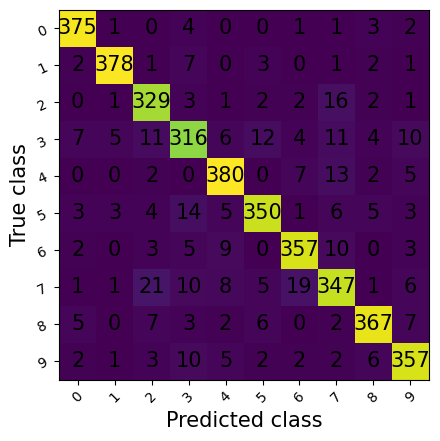

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9064679741859436     │
│          test_f1          │    0.9059368371963501     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.9064679741859436, 'test_f1': 0.9059368371963501}]

In [10]:
trainer.test(
    model=ClassificationModel(alexnet_pre, experiment),
    datamodule=imagenette_dm,
    ckpt_path=(Path.cwd()/"trained_models"/"alexnet_pretrained_acc=0.9.ckpt"),
)